In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

### Importing required libraries

In [2]:
import numpy as np 
import pandas  as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import GlobalAveragePooling2D
from keras.applications import Xception
from keras.models import Model

2024-04-01 20:04:20.568640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 20:04:20.568739: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 20:04:20.726380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Train Dataframe

In [3]:
# Directory path
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'

# List to store image paths and labels
all_paths = []
all_labels = []

# Dictionary to map folder names to labels
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

# Iterate through each folder
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # -1 if folder name not in label_mapping
        if label != -1:
            # Iterate through images in the folder
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                all_paths.append(image_path)
                all_labels.append(label)

# Create DataFrame
train_df = pd.DataFrame({'path': all_paths, 'label': all_labels})

# Display the first few rows of the DataFrame
train_df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [4]:
train_df.shape

(5216, 2)

### validation Dataframe

In [5]:
# Directory path
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

# List to store image paths and labels
all_paths = []
all_labels = []

# Dictionary to map folder names to labels
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

# Iterate through each folder
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # -1 if folder name not in label_mapping
        if label != -1:
            # Iterate through images in the folder
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                all_paths.append(image_path)
                all_labels.append(label)

# Create DataFrame
val_df = pd.DataFrame({'path': all_paths, 'label': all_labels})

# Display the first few rows of the DataFrame

val_df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [6]:
val_df.shape

(16, 2)

### Test Dataframe

In [7]:
# Directory path
base_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

# List to store image paths and labels
all_paths = []
all_labels = []

# Dictionary to map folder names to labels
label_mapping = {'NORMAL': 0, 'PNEUMONIA': 1}

# Iterate through each folder
for folder_name in os.listdir(base_dir):
    folder_path = os.path.join(base_dir, folder_name)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        label = label_mapping.get(folder_name, -1)  # -1 if folder name not in label_mapping
        if label != -1:
            # Iterate through images in the folder
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                all_paths.append(image_path)
                all_labels.append(label)

# Create DataFrame
test_df = pd.DataFrame({'path': all_paths, 'label': all_labels})

# Display the first few rows of the DataFrame

test_df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [8]:
test_df.shape

(624, 2)

### Concatenate the two Train, validation and Test dataframe

In [9]:
# Concatenate the three dataframes
df = pd.concat([train_df,val_df, test_df], ignore_index=True)

df.head()

,path,label
0,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
1,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
2,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
3,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1
4,/kaggle/input/chest-xray-pneumonia/chest_xray/...,1


In [10]:
df.shape

(5856, 2)

<Axes: xlabel='label', ylabel='count'>

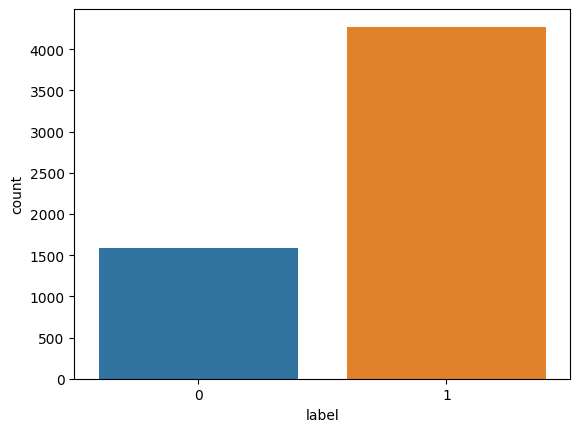

In [11]:
sns.countplot(data=df,x="label")

In [12]:
df["label"].value_counts()

label
1    4273
0    1583
Name: count, dtype: int64

In [13]:
# Convert numerical labels to strings
df['label'] = df['label'].astype(str)

### Splitting Training and Testing

In [14]:
from sklearn.model_selection import train_test_split

# Calculate the number of images for each class in the test set
test_size_percent = 0.1
num_responders_test = round(2166 * test_size_percent)  # Round to the nearest integer
num_non_responders_test = round(3249 * test_size_percent)  # Round to the nearest integer

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=test_size_percent, stratify=df['label'], random_state=42)

# Displaying the shapes of the resulting DataFrames
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Print the number of images in each class for the test set
print("Number of Responders in Test Set:", num_responders_test)
print("Number of Non_Responders in Test Set:", num_non_responders_test)

Train set shape: (5270, 2)
Test set shape: (586, 2)
Number of Responders in Test Set: 217
Number of Non_Responders in Test Set: 325


### Splitting Training and Validation

In [15]:
# Using cross validation cv=5

In [16]:
from sklearn.model_selection import StratifiedKFold

# Set up StratifiedKFold with 5 folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize lists to store training and validation sets
fold_train_dfs = []
fold_val_dfs = []

# Split the training set into 5 folds
for train_index, val_index in skf.split(train_df['path'], train_df['label']):
    train_fold = train_df.iloc[train_index]
    val_fold = train_df.iloc[val_index]
    
    # Append to the lists
    fold_train_dfs.append(train_fold)
    fold_val_dfs.append(val_fold)

# Print the number of images in each class for each fold
for fold, (train_fold, val_fold) in enumerate(zip(fold_train_dfs, fold_val_dfs), 1):
    print(f"Fold {fold} - Training Set Class Distribution:")
    print(train_fold['label'].value_counts())
    print(f"\nFold {fold} - Validation Set Class Distribution:")
    print(val_fold['label'].value_counts())
    print("\n" + "-"*40)


Fold 1 - Training Set Class Distribution:
label
1    3076
0    1140
Name: count, dtype: int64

Fold 1 - Validation Set Class Distribution:
label
1    769
0    285
Name: count, dtype: int64

----------------------------------------
Fold 2 - Training Set Class Distribution:
label
1    3076
0    1140
Name: count, dtype: int64

Fold 2 - Validation Set Class Distribution:
label
1    769
0    285
Name: count, dtype: int64

----------------------------------------
Fold 3 - Training Set Class Distribution:
label
1    3076
0    1140
Name: count, dtype: int64

Fold 3 - Validation Set Class Distribution:
label
1    769
0    285
Name: count, dtype: int64

----------------------------------------
Fold 4 - Training Set Class Distribution:
label
1    3076
0    1140
Name: count, dtype: int64

Fold 4 - Validation Set Class Distribution:
label
1    769
0    285
Name: count, dtype: int64

----------------------------------------
Fold 5 - Training Set Class Distribution:
label
1    3076
0    1140
Name: co

In [17]:
img_size = (224, 224)
batch_size = 32
num_classes = 2
epochs=10

In [18]:
# Create an ImageDataGenerator for preprocessing
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


In [19]:
from keras.optimizers import Adam
from keras import models
from keras import layers

def cnn_model(num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=1e-4) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Fold 1
Found 4216 validated image filenames belonging to 2 classes.
train_generator classes {'0': 0, '1': 1}
Found 1054 validated image filenames belonging to 2 classes.
val_generator classes {'0': 0, '1': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/132 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3984 - loss: 0.7658  

I0000 00:00:1712001891.878634      89 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1712001891.896031      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/132 ━━━━━━━━━━━━━━━━━━━━ 1:11 774ms/step - accuracy: 0.6284 - loss: 0.6622

W0000 00:00:1712001921.153645      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 548ms/step - accuracy: 0.7276 - loss: 0.5207

W0000 00:00:1712001964.980642      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 105s 689ms/step - accuracy: 0.7283 - loss: 0.5196 - val_accuracy: 0.9203 - val_loss: 0.1901 - learning_rate: 1.0000e-04
Epoch 2/10


W0000 00:00:1712001982.125022      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 335ms/step - accuracy: 0.9350 - loss: 0.1629 - val_accuracy: 0.9421 - val_loss: 0.1418 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 328ms/step - accuracy: 0.9527 - loss: 0.1325 - val_accuracy: 0.9507 - val_loss: 0.1370 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 334ms/step - accuracy: 0.9607 - loss: 0.1091 - val_accuracy: 0.9564 - val_loss: 0.1233 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 335ms/step - accuracy: 0.9656 - loss: 0.0993 - val_accuracy: 0.9573 - val_loss: 0.1156 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 330ms/step - accuracy: 0.9615 - loss: 0.1040 - val_accuracy: 0.9545 - val_loss: 0.1172 - learning_rate: 1.0000e-04
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 332ms/step - accuracy: 0.9632 - loss: 0.0978 - val_accuracy: 0.9620 - val_loss: 0.1128 - learning_rate: 1.0000e-04
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 330ms/step - 

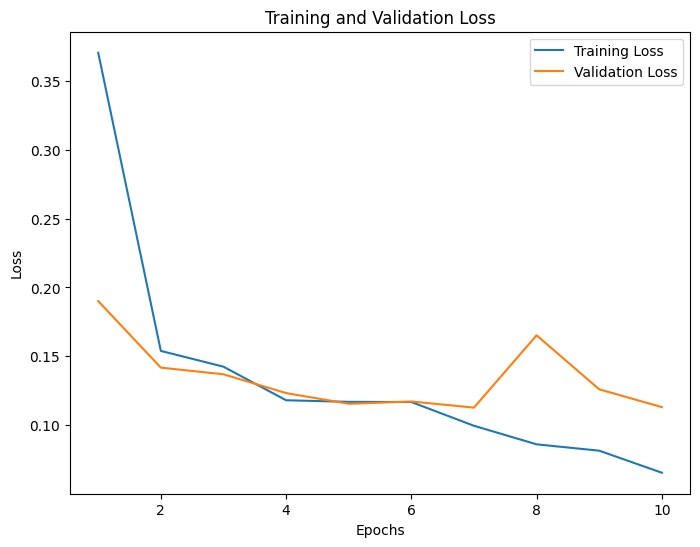

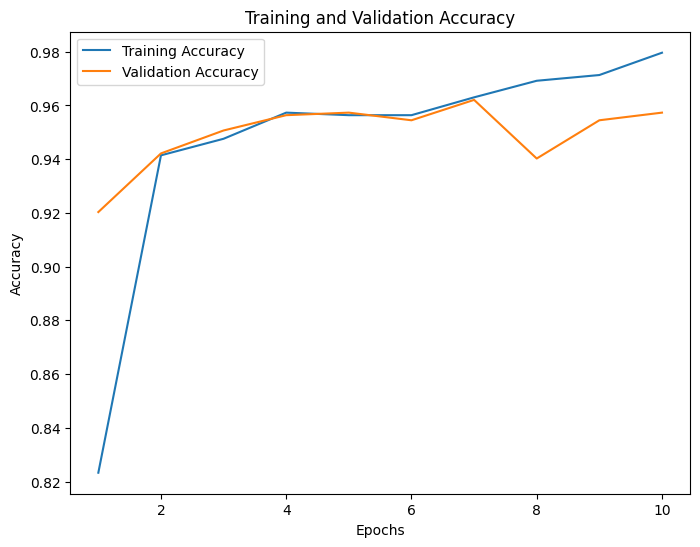

Fold 2
Found 4216 validated image filenames belonging to 2 classes.
train_generator classes {'0': 0, '1': 1}
Found 1054 validated image filenames belonging to 2 classes.
val_generator classes {'0': 0, '1': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.8125 - loss: 0.7374 

W0000 00:00:1712002398.421299      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/132 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.7968 - loss: 0.4764

W0000 00:00:1712002437.682901      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.8014 - loss: 0.4660

W0000 00:00:1712002439.885735      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 383ms/step - accuracy: 0.8019 - loss: 0.4649 - val_accuracy: 0.9402 - val_loss: 0.1583 - learning_rate: 1.0000e-04
Epoch 2/10


W0000 00:00:1712002448.628639      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 330ms/step - accuracy: 0.9447 - loss: 0.1457 - val_accuracy: 0.9469 - val_loss: 0.1463 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 0.9459 - loss: 0.1316 - val_accuracy: 0.9469 - val_loss: 0.1466 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 333ms/step - accuracy: 0.9627 - loss: 0.1035 - val_accuracy: 0.9526 - val_loss: 0.1319 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 334ms/step - accuracy: 0.9649 - loss: 0.1037 - val_accuracy: 0.9459 - val_loss: 0.1324 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 329ms/step - accuracy: 0.9667 - loss: 0.0963 - val_accuracy: 0.9497 - val_loss: 0.1340 - learning_rate: 1.0000e-04
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 328ms/step - accuracy: 0.9780 - loss: 0.0676 - val_accuracy: 0.9516 - val_loss: 0.1283 - learning_rate: 2.0000e-05
Epoch 8/10
106/132 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - a

W0000 00:00:1712002899.221563      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7660 - loss: 0.5111

W0000 00:00:1712002906.116647      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 386ms/step - accuracy: 0.7665 - loss: 0.5099 - val_accuracy: 0.9298 - val_loss: 0.1815 - learning_rate: 1.0000e-04
Epoch 2/10


W0000 00:00:1712002915.284239      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 323ms/step - accuracy: 0.9431 - loss: 0.1701 - val_accuracy: 0.9469 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 328ms/step - accuracy: 0.9506 - loss: 0.1341 - val_accuracy: 0.9469 - val_loss: 0.1444 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 335ms/step - accuracy: 0.9586 - loss: 0.1100 - val_accuracy: 0.9317 - val_loss: 0.1722 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 329ms/step - accuracy: 0.9580 - loss: 0.1124 - val_accuracy: 0.9507 - val_loss: 0.1363 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 336ms/step - accuracy: 0.9660 - loss: 0.1027 - val_accuracy: 0.9497 - val_loss: 0.1426 - learning_rate: 1.0000e-04
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 333ms/step - accuracy: 0.9748 - loss: 0.0698 - val_accuracy: 0.9497 - val_loss: 0.1377 - learning_rate: 1.0000e-04
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - 

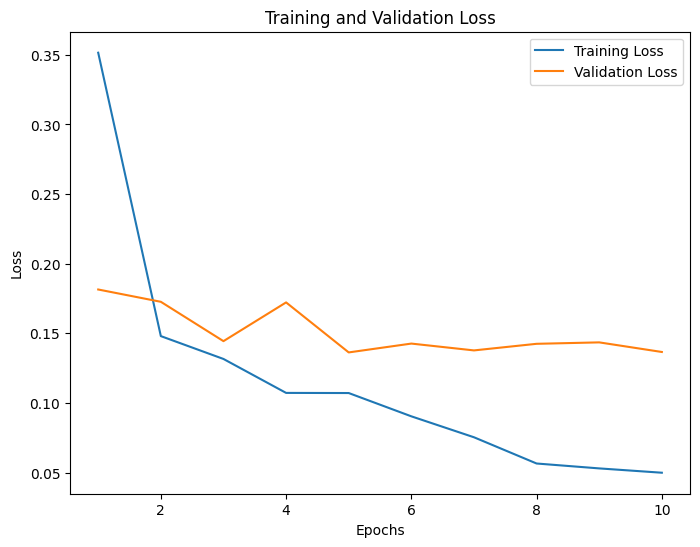

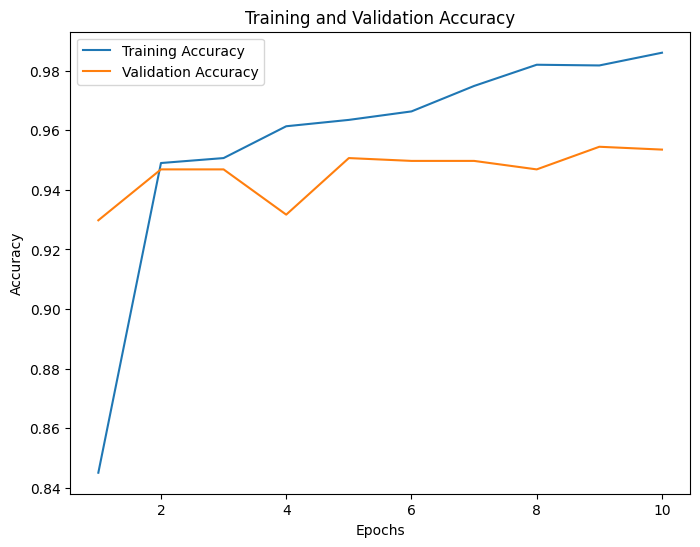

Fold 4
Found 4216 validated image filenames belonging to 2 classes.
train_generator classes {'0': 0, '1': 1}
Found 1054 validated image filenames belonging to 2 classes.
val_generator classes {'0': 0, '1': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/132 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - accuracy: 0.3672 - loss: 0.7227 

W0000 00:00:1712003333.506622      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/132 ━━━━━━━━━━━━━━━━━━━━ 1:10 623ms/step - accuracy: 0.6246 - loss: 0.7292

W0000 00:00:1712003344.588671      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7684 - loss: 0.4933

W0000 00:00:1712003375.186667      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 386ms/step - accuracy: 0.7689 - loss: 0.4922 - val_accuracy: 0.9450 - val_loss: 0.1641 - learning_rate: 1.0000e-04
Epoch 2/10


W0000 00:00:1712003384.091946      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 337ms/step - accuracy: 0.9432 - loss: 0.1579 - val_accuracy: 0.9573 - val_loss: 0.1421 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 49s 357ms/step - accuracy: 0.9439 - loss: 0.1343 - val_accuracy: 0.9535 - val_loss: 0.1335 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - accuracy: 0.9604 - loss: 0.0986 - val_accuracy: 0.9620 - val_loss: 0.1089 - learning_rate: 1.0000e-04
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 339ms/step - accuracy: 0.9647 - loss: 0.0929 - val_accuracy: 0.9696 - val_loss: 0.1054 - learning_rate: 1.0000e-04
Epoch 8/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 330ms/step - accuracy: 0.9764 - loss: 0.0668 - val_accuracy: 0.9611 - val_loss: 0.1090 - learning_rate: 1.0000e-04
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 330ms/step - accuracy: 0.9793 - loss: 0.0620 - val_accuracy: 0.9611 - val_loss: 0.1188 - learning_rate: 1.0000e-04
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 329ms/step -

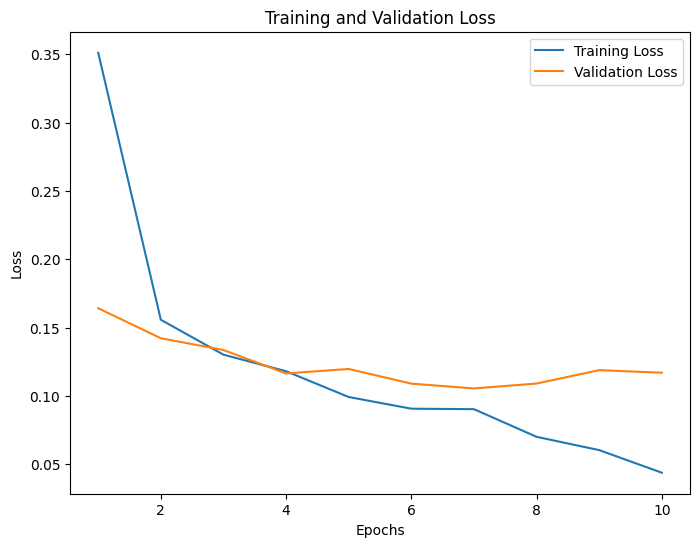

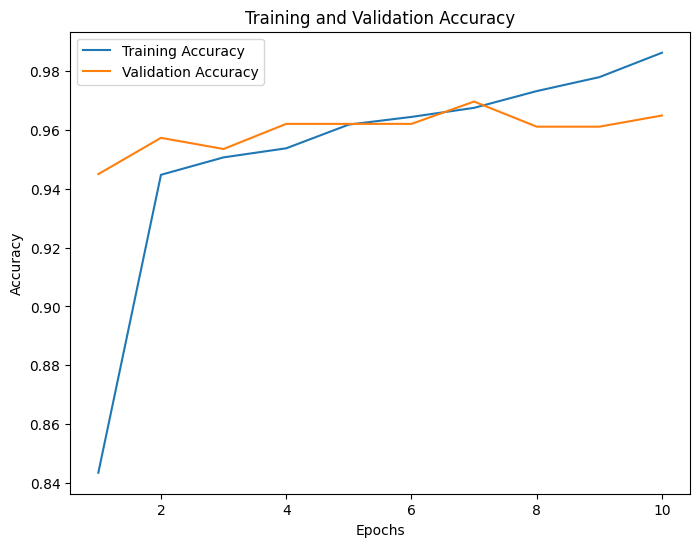

Fold 5
Found 4216 validated image filenames belonging to 2 classes.
train_generator classes {'0': 0, '1': 1}
Found 1054 validated image filenames belonging to 2 classes.
val_generator classes {'0': 0, '1': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/132 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.7812 - loss: 0.7564

W0000 00:00:1712003811.645097      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/132 ━━━━━━━━━━━━━━━━━━━━ 55s 524ms/step - accuracy: 0.7381 - loss: 0.6591

W0000 00:00:1712003824.613123      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8075 - loss: 0.4671

W0000 00:00:1712003853.143366      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - accuracy: 0.8080 - loss: 0.4660 - val_accuracy: 0.9364 - val_loss: 0.1680 - learning_rate: 1.0000e-04
Epoch 2/10


W0000 00:00:1712003862.071808      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 331ms/step - accuracy: 0.9362 - loss: 0.1695 - val_accuracy: 0.9412 - val_loss: 0.1375 - learning_rate: 1.0000e-04
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 337ms/step - accuracy: 0.9523 - loss: 0.1359 - val_accuracy: 0.9545 - val_loss: 0.1343 - learning_rate: 1.0000e-04
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 333ms/step - accuracy: 0.9499 - loss: 0.1281 - val_accuracy: 0.9469 - val_loss: 0.1281 - learning_rate: 1.0000e-04
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 333ms/step - accuracy: 0.9664 - loss: 0.0988 - val_accuracy: 0.9488 - val_loss: 0.1251 - learning_rate: 1.0000e-04
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 335ms/step - accuracy: 0.9806 - loss: 0.0634 - val_accuracy: 0.9516 - val_loss: 0.1305 - learning_rate: 2.0000e-05
Epoch 9/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 331ms/step - accuracy: 0.9808 - loss: 0.0599 - val_accuracy: 0.9488 - val_loss: 0.1248 - learning_rate: 2.0000e-05
Epoch 10/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 46s 337ms/step -

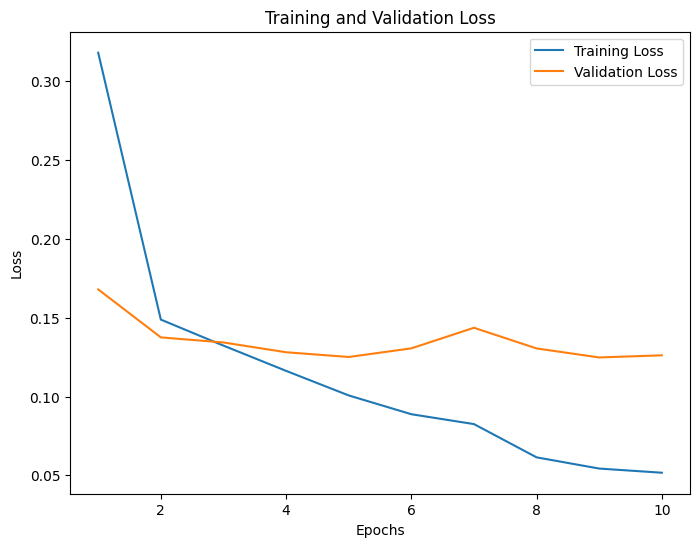

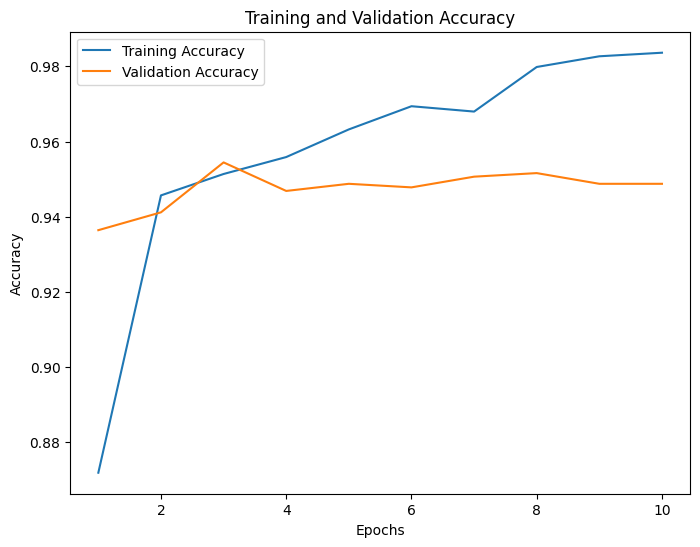

In [20]:
# Initialize lists to store loss and accuracy values
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Initialize EarlyStopping and ReduceLROnPlateau callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)


# Loop through the folds and fit the model
for i in range(5):
    print("Fold", i + 1)
    # Get the current fold's training and validation sets
    fold_train = fold_train_dfs[i]
    fold_val = fold_val_dfs[i]

    # Training generator
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=fold_train,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("train_generator classes", train_generator.class_indices)

    # Validation generator
    val_generator = val_datagen.flow_from_dataframe(
        dataframe=fold_val,
        x_col='path',
        y_col='label',
        target_size=img_size,  
        batch_size=batch_size,
        seed=42,
        shuffle=True,
        class_mode='sparse'
    )
    print("val_generator classes", val_generator.class_indices)
    
    # Build and compile the model
    model = cnn_model(num_classes)

    # Train the model

    # Fit the model on the current fold's training and validation data
    history = model.fit(
        train_generator,
        epochs=epochs,
        verbose=1,
        validation_data=val_generator,
        callbacks=[reduce_lr]
        #callbacks=[early_stop, reduce_lr]  # Add callbacks
    )

    # Print the training and validation loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    print("Training Loss:", train_loss)
    print("Validation Loss:", val_loss)
    print("Training Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)

    # Append the loss and accuracy values to the lists
    all_train_loss.append(train_loss)
    all_val_loss.append(val_loss)
    all_train_acc.append(train_acc)
    all_val_acc.append(val_acc)

    # Plot the training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_loss, label='Training Loss')
    plt.plot(range(1, len(history.epoch) + 1), val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    # Plot the training and validation accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, len(history.epoch) + 1), train_acc, label='Training Accuracy')
    plt.plot(range(1, len(history.epoch) + 1), val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [24]:
# Calculate and print the average loss and accuracy
avg_train_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_train_loss]
avg_val_loss = [sum(epoch_loss) / len(epoch_loss) for epoch_loss in all_val_loss]
avg_train_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_train_acc]
avg_val_acc = [sum(epoch_acc) / len(epoch_acc) for epoch_acc in all_val_acc]

print("Average Training Loss:", avg_train_loss)
print("Average Validation Loss:", avg_val_loss)
print("Average Training Accuracy:", avg_train_acc)
print("Average Validation Accuracy:", avg_val_acc)


Average Training Loss: [0.1351538859307766, 0.11875799298286438, 0.11706335917115211, 0.12088908106088639, 0.11548087187111378]
Average Validation Loss: [0.13422625586390496, 0.13579233288764953, 0.15099508613348006, 0.12349055260419846, 0.13485838770866393]
Average Training Accuracy: [0.9465369999408721, 0.9554316937923432, 0.9560483872890473, 0.9523719191551209, 0.9571631968021392]
Average Validation Accuracy: [0.9495256185531616, 0.9491461098194123, 0.9460151851177215, 0.9598671853542328, 0.9475332081317902]


In [25]:
# Calculate and print the average loss and accuracy
mean_train_loss = sum(avg_train_loss) / len(avg_train_loss)
mean_val_loss = sum(avg_val_loss) / len(avg_val_loss)
mean_train_acc = sum(avg_train_acc) / len(avg_train_acc)
mean_val_acc = sum(avg_val_acc) / len(avg_val_acc)

print("Mean Training Loss:", mean_train_loss)
print("Mean Validation Loss:", mean_val_loss)
print("Mean Training Accuracy:", mean_train_acc)
print("Mean Validation Accuracy:", mean_val_acc)


Mean Training Loss: 0.12146903820335866
Mean Validation Loss: 0.13587252303957936
Mean Training Accuracy: 0.9535104393959045
Mean Validation Accuracy: 0.9504174613952637


In [26]:
# Evaluate the model on the evaluation set
evaluation_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    seed=1234,
    shuffle=False,
    class_mode='sparse'
)
print("evaluation_generator classes", evaluation_generator.class_indices)

evaluation_loss, evaluation_accuracy = model.evaluate(evaluation_generator)

print("Evaluation Loss:", evaluation_loss)
print("Evaluation Accuracy:", evaluation_accuracy)

Found 586 validated image filenames belonging to 2 classes.
evaluation_generator classes {'0': 0, '1': 1}


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - accuracy: 0.9665 - loss: 0.0960
Evaluation Loss: 0.10928648710250854
Evaluation Accuracy: 0.9658703207969666


### Evaluation Accuracy: 96.58%

# Thank you!